# Функция Розенброка <!-- Rosenbrock-like test function -->
Обновлено 04.11.2020

#### Двумерная функция Розенброка <!-- 2-dimensional Rosenbrock function -->
$$f(x) = 100 (x_2 - x_1^2)^2 + (1 - x_1)^2 $$

Минимум достигается в $x^* = [1, 1]$  
Градиент $$\nabla f(x) = \left[\begin{array}{c} 400(x_1^2 - x_2)x_1 + 2(x_1 - 1) \\ 200 (x_2 - x_1^2) \end{array}\right]$$
<!-- Minimum at  $[1, 1].$ -->
<!-- Its gradient is $$\nabla f(x) = \left[\begin{array}{c} 400(x_1^2 - x_2)x_1 + 2(x_1 - 1) \\ 200 (x_2 - x_1^2) \end{array}\right]$$ -->

<!-- Starting points for algorithms: -->
Начальные точки алгоритмов:
$$x^a = [0, 0]^T$$
$$x^b = [-1, -1]^T$$
$$x^c = [-0.9, -0.8]^T$$
$$x^d = [-0.9, 1.1]^T$$


In [1]:
import math
from typing import Callable, List, Dict

import numpy as np

array = np.ndarray

In [2]:
# utils


def rosen2d_xy(x: array, y: array) -> array:
    return 100 * (y - x ** 2) ** 2 + (1 - x) ** 2


def rosen(x: array):
    """The Rosenbrock function"""
    return np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0, axis=0)


def rosen_grad(x: array) -> array:
    """The gradient of The Rosenbrock function"""
    xm = x[1: -1]
    xm_m1 = x[: - 2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1: -1] = 200 * (xm - xm_m1 ** 2) - 400 * (xm_p1 - xm ** 2) * xm - 2 * (1 - xm)
    der[0] = -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0])
    der[-1] = 200 * (x[-1] - x[-2] ** 2)
    return der


def armijo(x: array, alpha: float, theta: float, epsilon: float, f: Callable, f_grad: Callable) -> float:
    fg = f_grad(x)
    fx = f(x)
    _alpha = alpha
    while f(x - _alpha * fg) > fx - epsilon * _alpha * (np.dot(fg, fg)):
        _alpha *= theta
    return _alpha


def werewolf(state: List[bool] = [True]) -> array:  # noqa
    state[0] = not state[0]
    return np.array([1, 0]) if state[0] else np.array([0, 1])


def check_precision(precision: float, x_array: list, f: Callable) -> bool:
    return len(x_array) == 1 or abs(f(x_array[-1]) - f(x_array[-2])) > precision

In [3]:
# solvers


def solver(
        x0: array,
        f: Callable,
        f_grad: Callable,
        gamma: Callable,
        iterations=70,
        precision=1e-6
) -> Dict[str, list]:
    """ Общая модель солверов """
    x = x0.copy()
    x_array, f_array = [x], [f(x)]
    k = 0

    while k < iterations and check_precision(precision, x_array, f):
        x = x + gamma(x) * (-f_grad(x))
        x_array.append(x)
        f_array.append(f(x))
        k += 1

    print(f'{k} iterations is taken, f(x^k) = {f_array[-1]}')
    return {'x_k': x_array, 'f_k': f_array}


def grad_solver(x0: array, f: Callable, f_grad: Callable, iterations=70, precision=1e-6):
    return solver(x0, f, f_grad, lambda x: armijo(x, 10., -.5, .01, f, f_grad), iterations, precision)


def coord_solver(x0: array, f: Callable, f_grad: Callable, iterations=70, precision=1e-6):
    x = x0.copy()
    x_array, f_array = [x], [f(x)]
    alpha, epsilon, theta = 10., 0.01, -.5
    f_star, tmp = 0, [True]
    k = 0

    while k < iterations:
        fg, gamma = werewolf(tmp), alpha
        while f(x + gamma * fg) > f(x) - epsilon * gamma * (np.dot(f_grad(x), fg)):
            gamma *= theta
        x = x + gamma * fg
        x_array.append(x)
        f_array.append(f(x))
        if abs(f(x_array[k]) - f_star) < precision:
            break
        k += 1

    print(f'{k} iterations is taken, f(x^k) = {f_array[-1]}')
    return {'x_k': x_array, 'f_k': f_array}

In [4]:
import matplotlib.pyplot as plt


def draw_rosen(first, second):
    # plot Rosenbrock contours
    x, y = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 3, 400))  # noqa
    z_rosen = rosen2d_xy(x, y)

    # minimum
    f_star = 0
    x_star = np.array([1, 1])

    _, axes = plt.subplots(1, 2, figsize=(18, 10))
    for k in range(2):
        axes[k].plot([1], [1], 'x')
        axes[k].contour(x, y, z_rosen, np.logspace(-1, 3, 10))

    for i, data in enumerate([first, second]):
        x_data = np.array(data['x_k'])
        axes[i].set_title('Contours of Rosenbrock function')
        axes[i].plot(x_data[:, 0], x_data[:, 1], )

    # residuals
    _, axes = plt.subplots(4, 2, figsize=(15, 10))
    plt.tight_layout()

    # for both columns:
    for j, data in enumerate([first, second]):
        # draw grid in all sub-plots
        for m in range(4):
            axes[m][j].grid()

        x_data = np.array(data['x_k'])
        f_k_residual = np.array(data['f_k']) - f_star

        N = len(f_k_residual)  # noqa
        # broadcasting!
        x_k_residual = x_data - x_star

        axes[0][j].set_title('Function residual')
        axes[0][j].plot(f_k_residual, )
        axes[1][j].set_title('Logarithmic function residual')
        axes[1][j].plot(np.log(f_k_residual), )
        axes[2][j].set_title('Value residual (Euclidean norm)')
        axes[2][j].plot(np.arange(N), np.linalg.norm(x_k_residual, axis=1))
        axes[3][j].set_title('Logarithmic value residual (Euclidean norm)')
        axes[3][j].plot(np.arange(N), np.log(np.linalg.norm(x_k_residual, axis=1)))

    plt.show()

In [5]:
x_a = np.array([0, 0])
x_b = np.array([-1, -1])
x_c = np.array([-0.9, -0.8])
x_d = np.array([-0.9, 1.1])

6332 iterations is taken, f(x^k) = 8.816805567037702e-07
6587 iterations is taken, f(x^k) = 9.978353154921261e-11


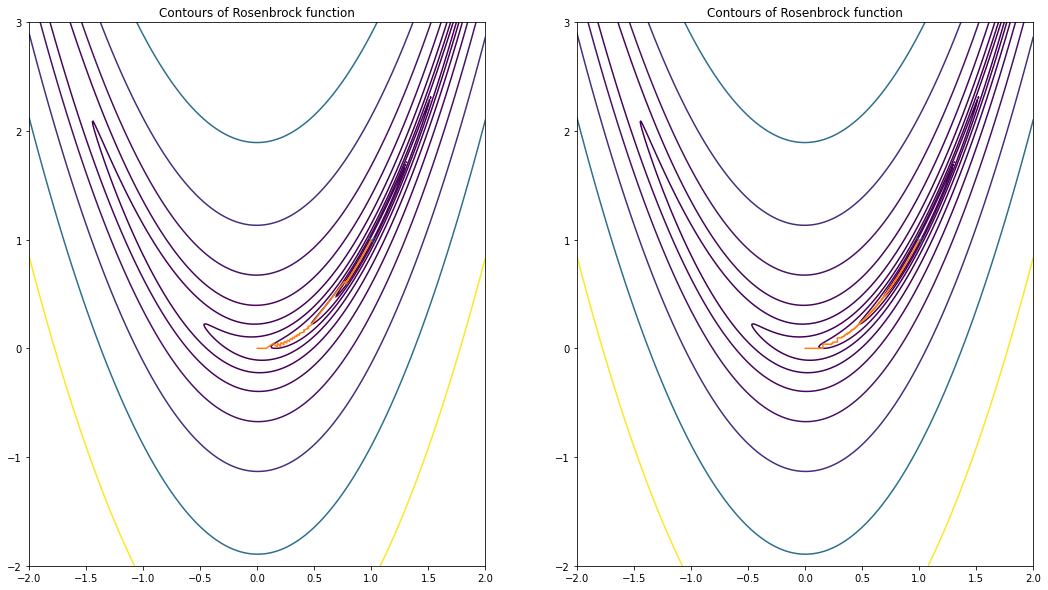

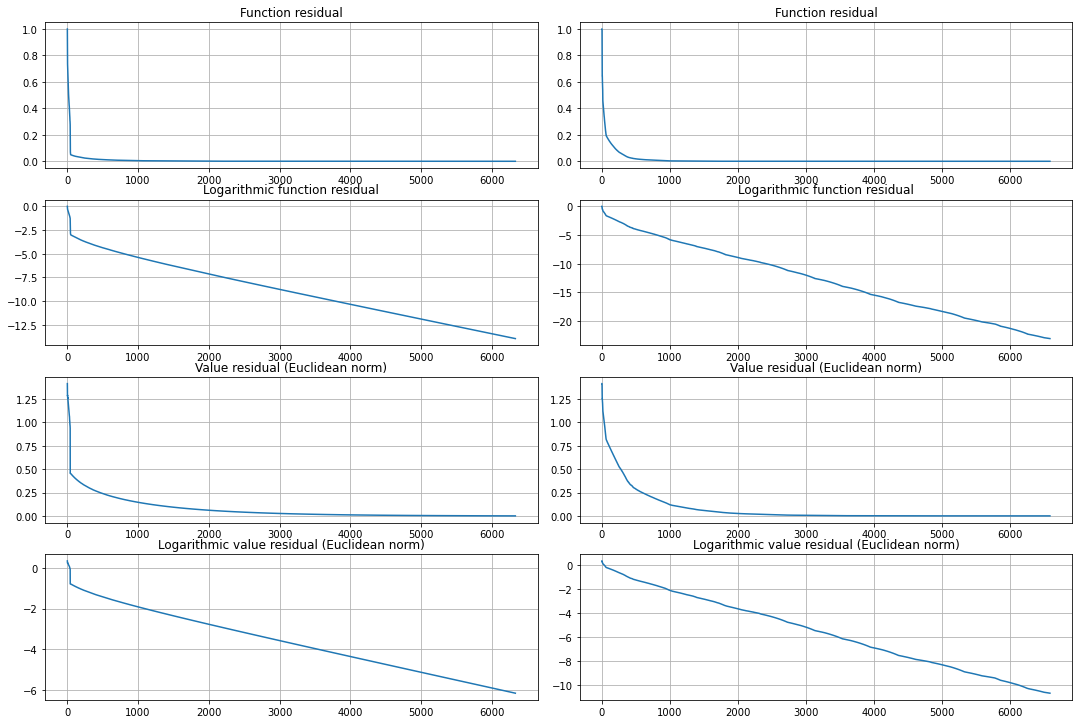

In [6]:
# first = solver(x_a, rosen, rosen_der, lambda x: 1e-4, 1e5, 1e-10)  # const step solver
first = grad_solver(x_a, rosen, rosen_grad, 1e5, 1e-10)
second = coord_solver(x_a, rosen, rosen_grad, 1e5, 1e-10)

draw_rosen(first, second)

6442 iterations is taken, f(x^k) = 7.53979247884334e-07
6862 iterations is taken, f(x^k) = 9.982237499960739e-11


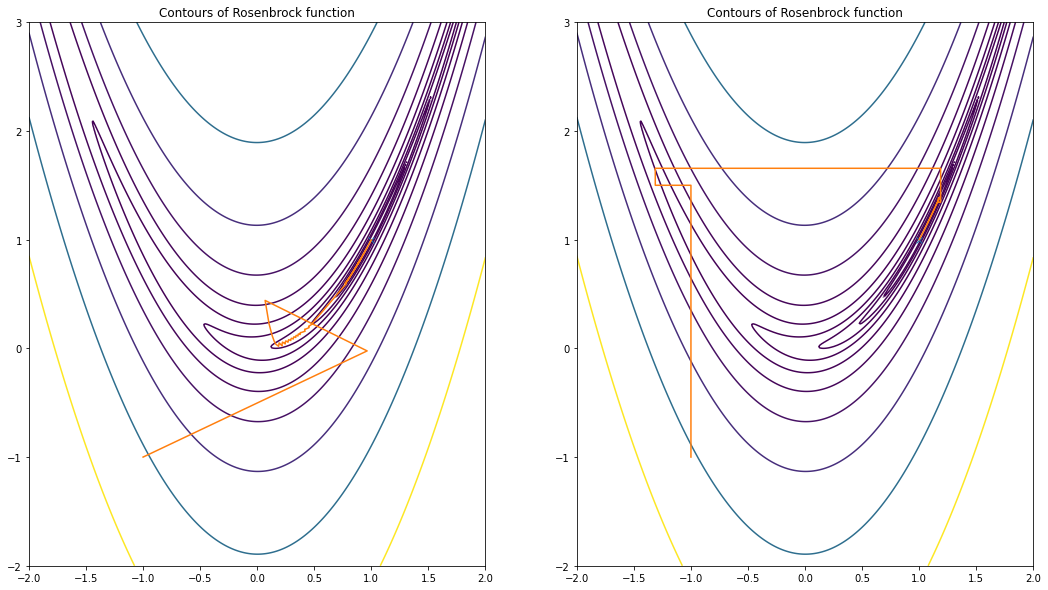

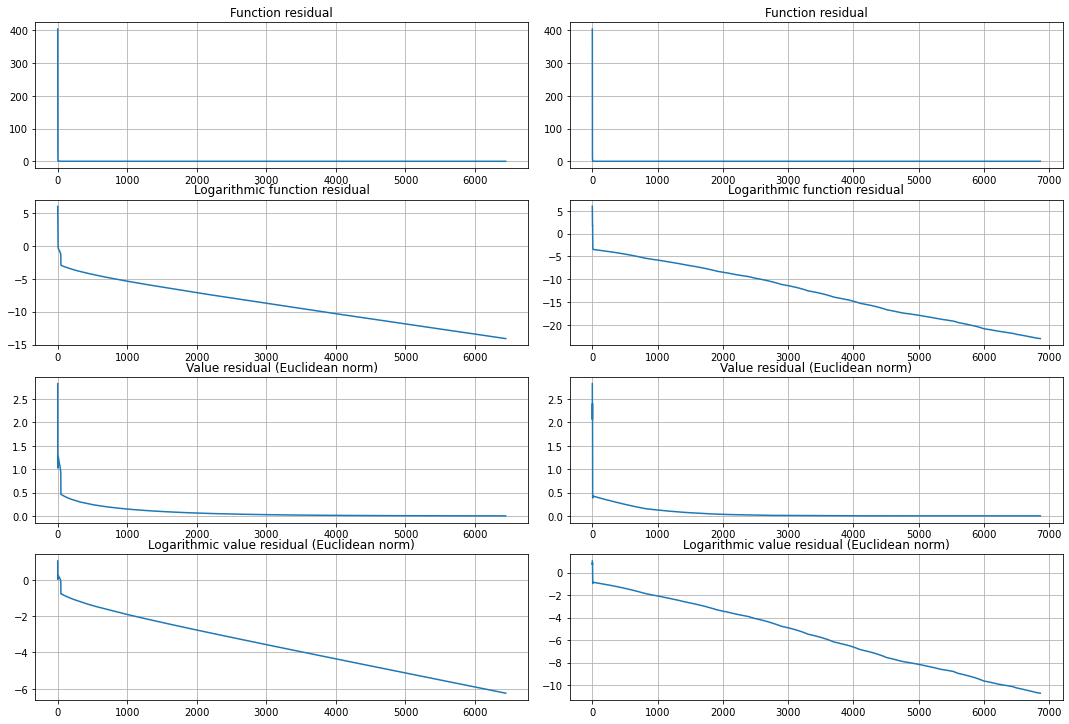

In [7]:
first = grad_solver(x_b, rosen, rosen_grad, 1e5, 1e-10)
second = coord_solver(x_b, rosen, rosen_grad, 1e5, 1e-10)

draw_rosen(first, second)

6405 iterations is taken, f(x^k) = 7.617293375172978e-07
8310 iterations is taken, f(x^k) = 9.985746777749392e-11


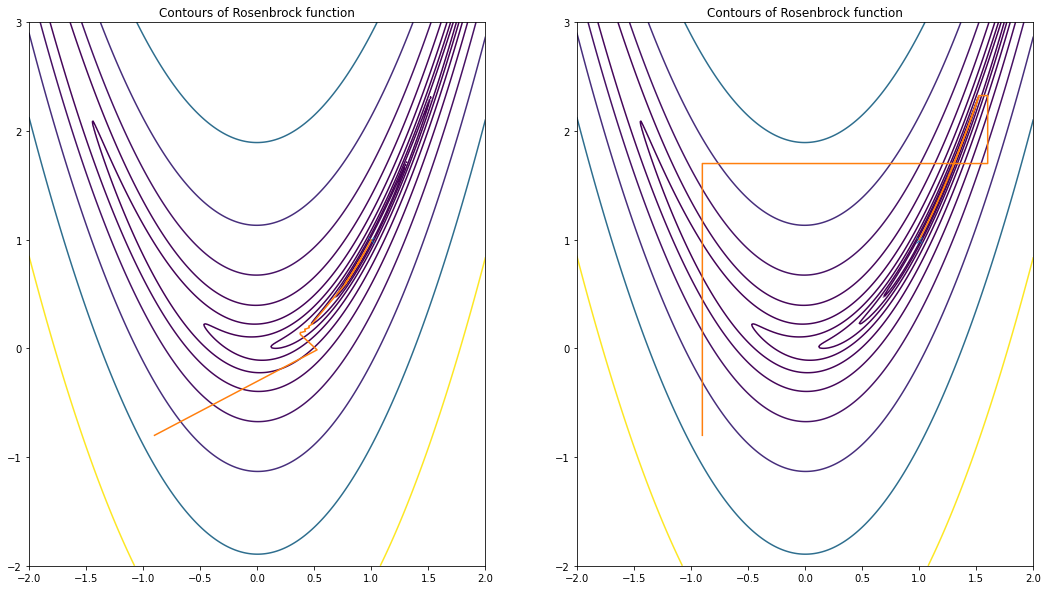

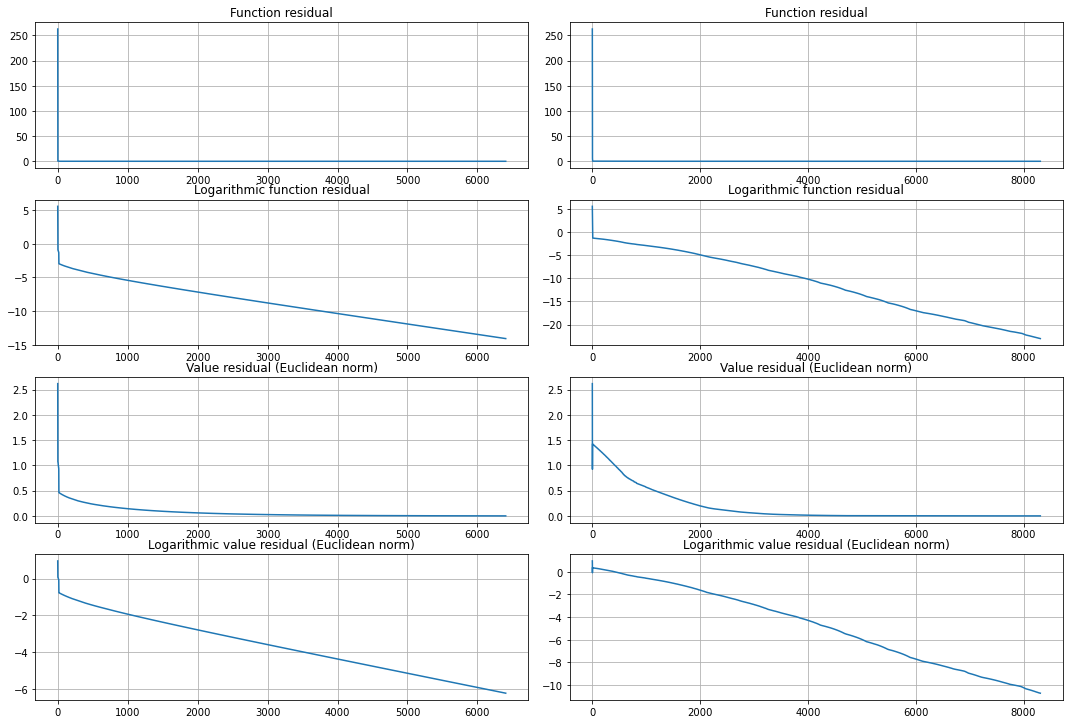

In [8]:
first = grad_solver(x_c, rosen, rosen_grad, 1e5, 1e-10)
second = coord_solver(x_c, rosen, rosen_grad, 1e5, 1e-10)

draw_rosen(first, second)

17114 iterations is taken, f(x^k) = 7.365887155927259e-07
7059 iterations is taken, f(x^k) = 9.969426251449478e-11


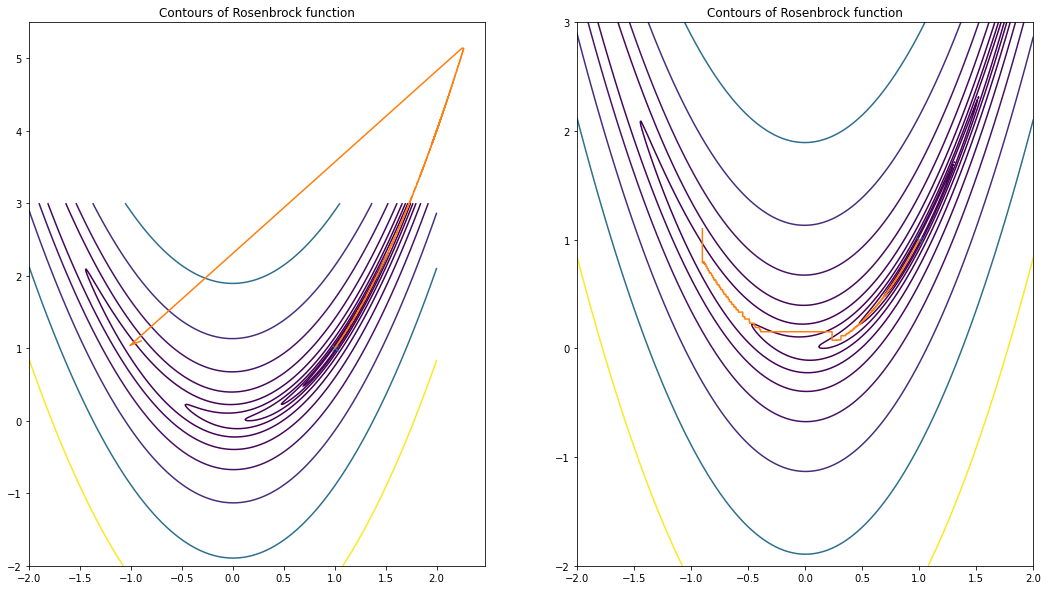

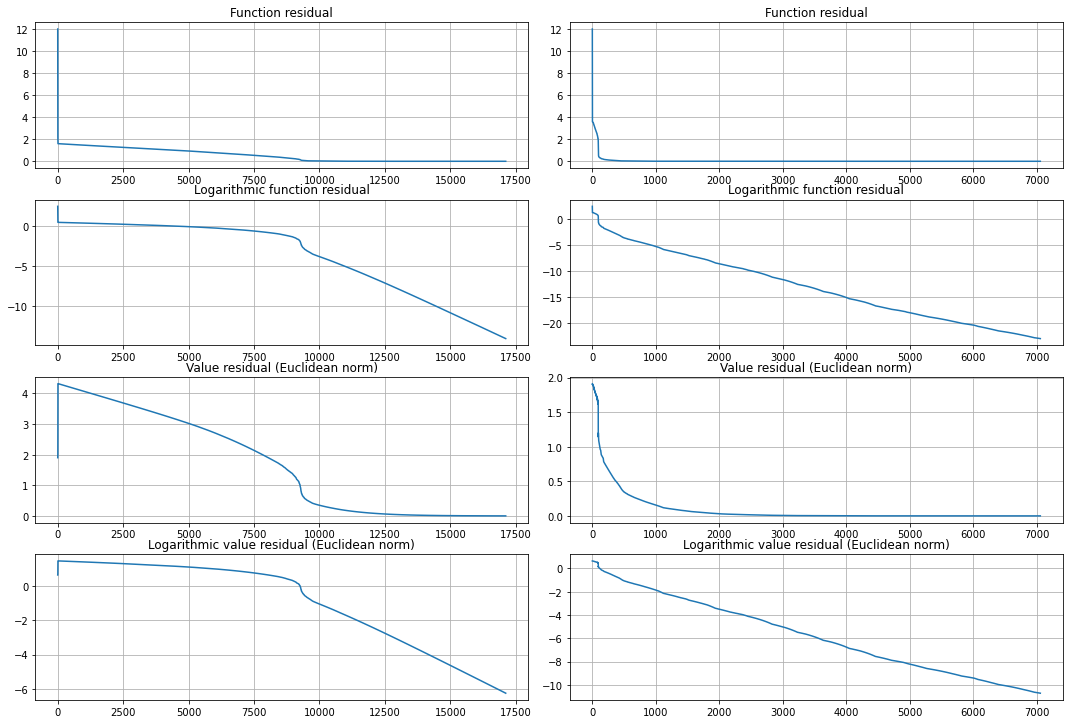

In [9]:
first = grad_solver(x_d, rosen, rosen_grad, 1e5, 1e-10)
second = coord_solver(x_d, rosen, rosen_grad, 1e5, 1e-10)

draw_rosen(first, second)